# 単回帰分析

説明変数（cpNum, cpNum_range, cpNum_dir, tree）と目的変数（バグ発見数、バグ発見までの時間、実行時間）の組み合わせで単回帰分析を実行し、グラフにプロット、決定係数を計算します。


In [42]:

# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (10, 6)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [43]:
# データ収集関数
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data(logs_root='Logs'):
    """
    全データを収集してDataFrameを作成
    各行（各実行）ごとに1つのデータポイントを作成
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            exe_time_path = param_dir / 'exe_time.csv'
            
            if not os.path.exists(detected_bugs_path) or not os.path.exists(exe_time_path):
                continue
            
            # まず、パラメータディレクトリ全体のバグ発見数をカウント
            total_bug_count = 0
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    if bug_row != ['null'] and bug_row != ['timeout']:
                        total_bug_count += 1
            
            # detected_bugs.csvとexe_time.csvの各行を読み込む（各実行ごとにデータポイントを作成）
            with open(detected_bugs_path, 'r') as bug_f, open(exe_time_path, 'r') as time_f:
                bug_reader = csv.reader(bug_f)
                time_reader = csv.reader(time_f)
                
                # 各行をペアで処理
                for bug_row, time_row in zip(bug_reader, time_reader):
                    # 実行時間を取得
                    try:
                        execution_time = int(time_row[0])
                    except (ValueError, IndexError):
                        continue
                    
                    # バグ発見数を判定（その行がバグかどうか）
                    is_bug = False
                    if bug_row != ['null'] and bug_row != ['timeout']:
                        is_bug = True
                    
                    # バグ発見までの時間を計算
                    # バグが発見された場合、その時点までの累積時間を記録
                    bug_time = None
                    if is_bug:
                        bug_time = execution_time
                    
                    # データポイントを作成
                    data_records.append({
                        'tree': tree_value,
                        'cpNum': cpnum,
                        'cpNum_range': cpnum_range,
                        'cpNum_dir': cpnum_dir,
                        'bug_count': total_bug_count,  # パラメータディレクトリ全体のバグ発見数
                        'bug_time': bug_time,  # バグ発見までの時間（バグが発見された場合のみ、各実行ごと）
                        'execution_time': execution_time  # その実行の実行時間（各実行ごと）
                    })
                    
                    # 累積時間を更新
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード（各行ごとに1つのデータポイント）")
    return df

# データ収集
df = collect_data()
print(f"\nデータの基本統計:")
print(df.describe())


データ収集完了: 10800件のレコード（各行ごとに1つのデータポイント）

データの基本統計:
               tree         cpNum   cpNum_range     cpNum_dir     bug_count  \
count  10800.000000  10800.000000  10800.000000  10800.000000  10800.000000   
mean     500.000000    225.000000     50.000000      1.150000      2.881019   
std      408.267192    234.016532     40.010185      0.572303      1.948549   
min        0.000000      1.000000      1.000000      1.000000      0.000000   
25%        0.000000     50.000000      1.000000      1.000000      1.000000   
50%      500.000000    149.500000     50.000000      1.000000      3.000000   
75%     1000.000000    300.000000     99.000000      1.000000      5.000000   
max     1000.000000    700.000000     99.000000      4.000000      5.000000   

            bug_time  execution_time  
count    6223.000000    10800.000000  
mean    23643.482886    28253.546389  
std     23903.914687    29980.425181  
min       966.000000      966.000000  
25%      5767.500000     7198.750000  
50%  


分析: cpNum vs バグ発見数
5


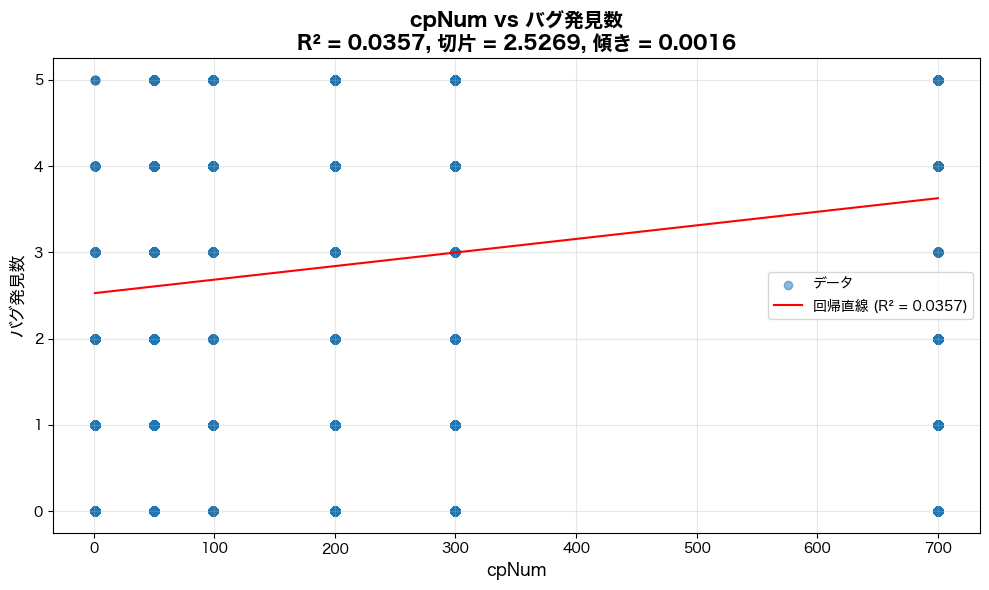


cpNum vs バグ発見数
  決定係数 (R²): 0.0357
  切片: 2.5269
  傾き: 0.0016
  サンプル数: 10800

分析: cpNum vs バグ発見までの時間
107936.0


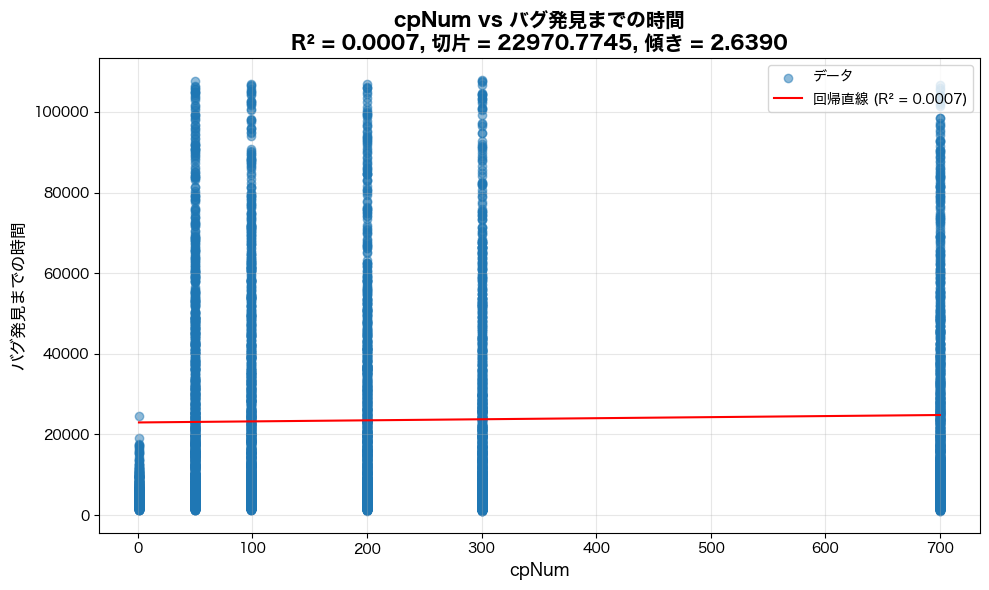


cpNum vs バグ発見までの時間
  決定係数 (R²): 0.0007
  切片: 22970.7745
  傾き: 2.6390
  サンプル数: 6223

分析: cpNum vs 実行時間
108000


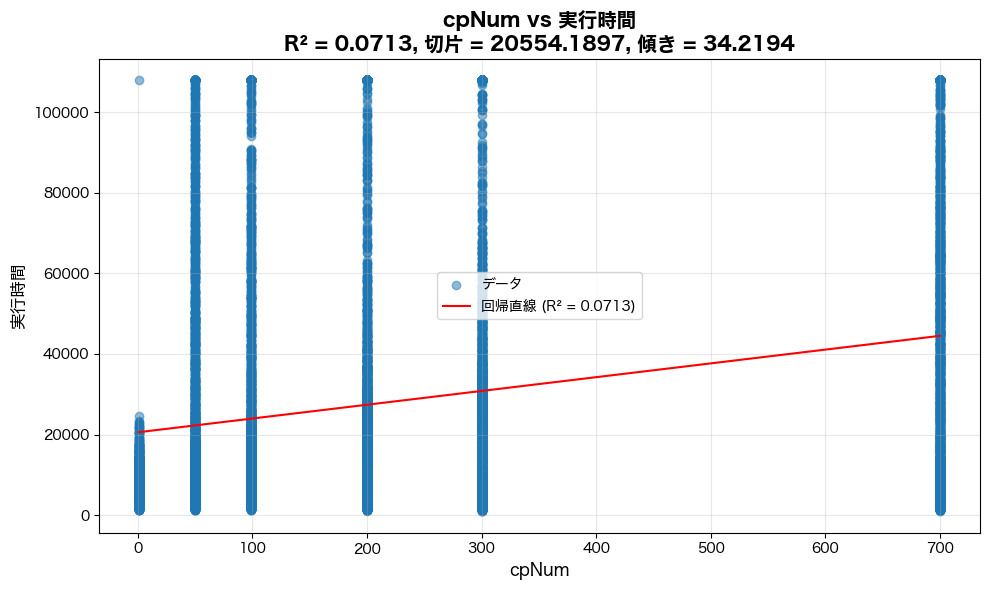


cpNum vs 実行時間
  決定係数 (R²): 0.0713
  切片: 20554.1897
  傾き: 34.2194
  サンプル数: 10800

分析: cpNum_range vs バグ発見数
5


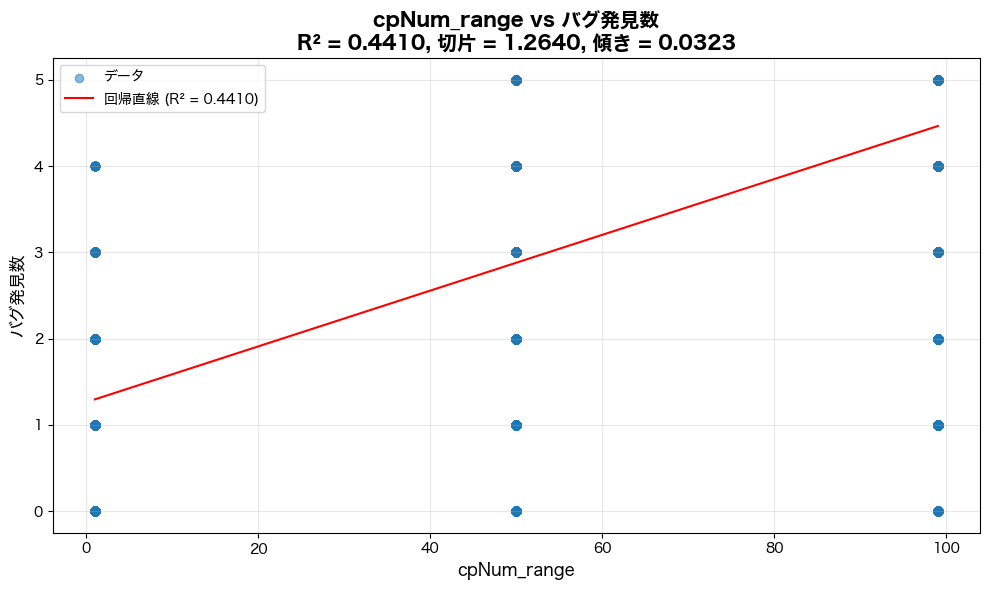


cpNum_range vs バグ発見数
  決定係数 (R²): 0.4410
  切片: 1.2640
  傾き: 0.0323
  サンプル数: 10800

分析: cpNum_range vs バグ発見までの時間
107936.0


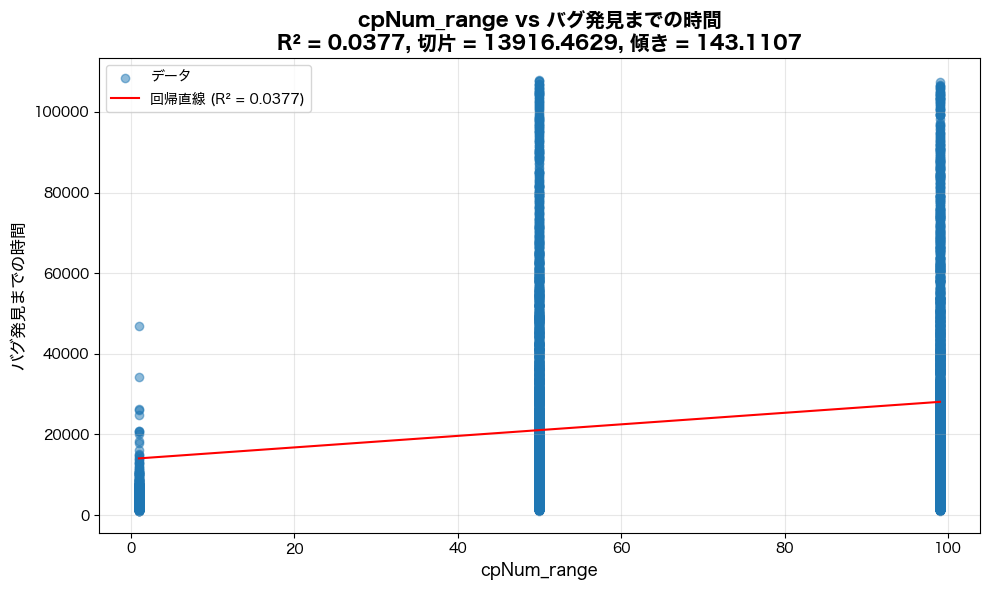


cpNum_range vs バグ発見までの時間
  決定係数 (R²): 0.0377
  切片: 13916.4629
  傾き: 143.1107
  サンプル数: 6223

分析: cpNum_range vs 実行時間
108000


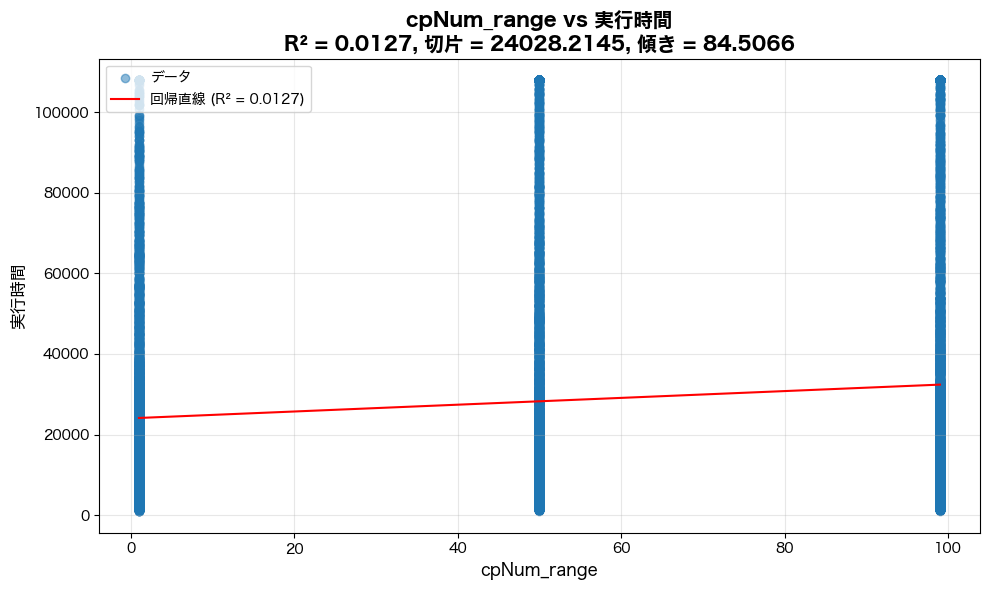


cpNum_range vs 実行時間
  決定係数 (R²): 0.0127
  切片: 24028.2145
  傾き: 84.5066
  サンプル数: 10800

分析: cpNum_dir vs バグ発見数
5


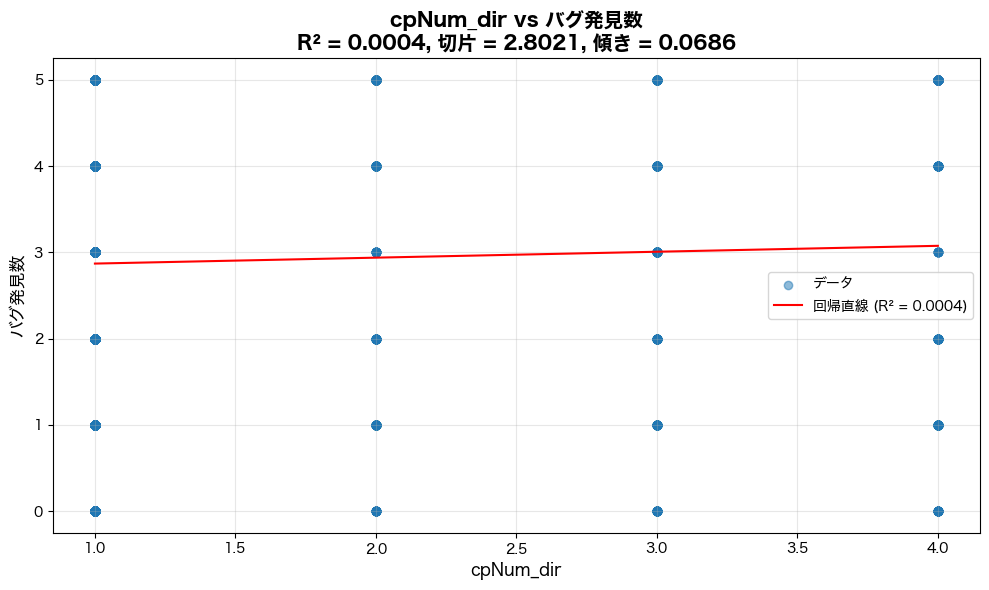


cpNum_dir vs バグ発見数
  決定係数 (R²): 0.0004
  切片: 2.8021
  傾き: 0.0686
  サンプル数: 10800

分析: cpNum_dir vs バグ発見までの時間
107936.0


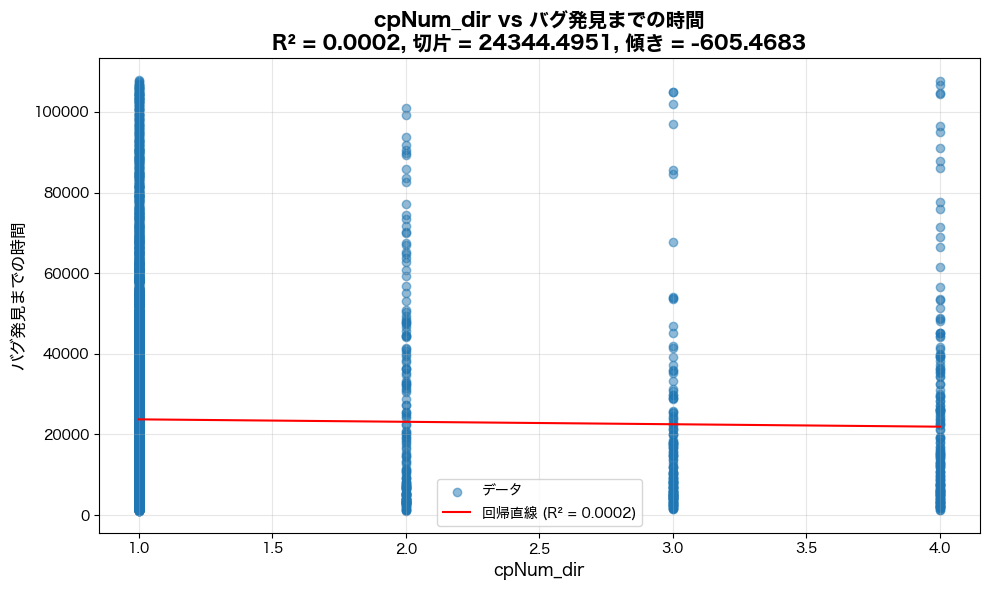


cpNum_dir vs バグ発見までの時間
  決定係数 (R²): 0.0002
  切片: 24344.4951
  傾き: -605.4683
  サンプル数: 6223

分析: cpNum_dir vs 実行時間
108000


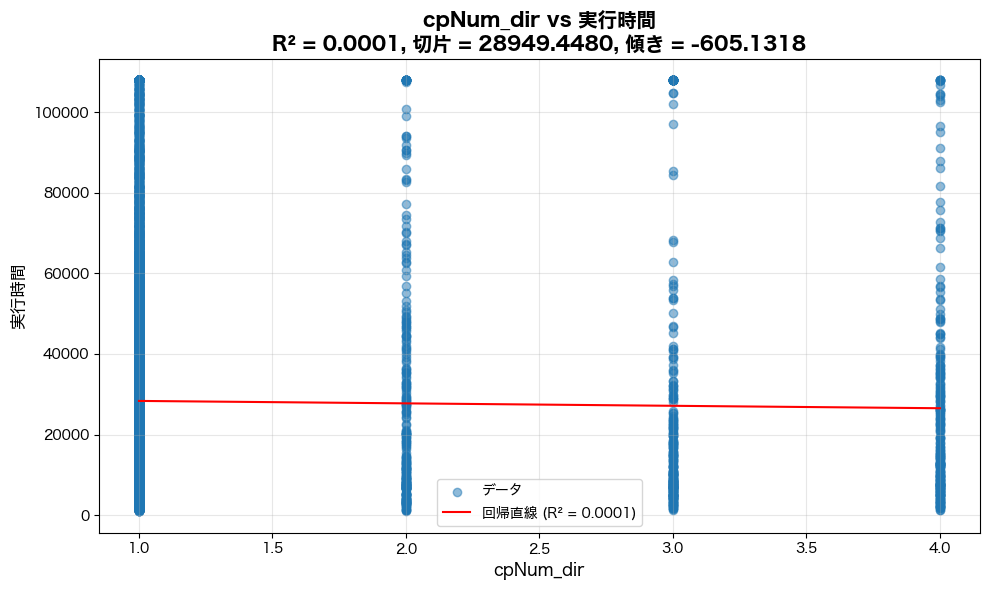


cpNum_dir vs 実行時間
  決定係数 (R²): 0.0001
  切片: 28949.4480
  傾き: -605.1318
  サンプル数: 10800

分析: tree vs バグ発見数
5


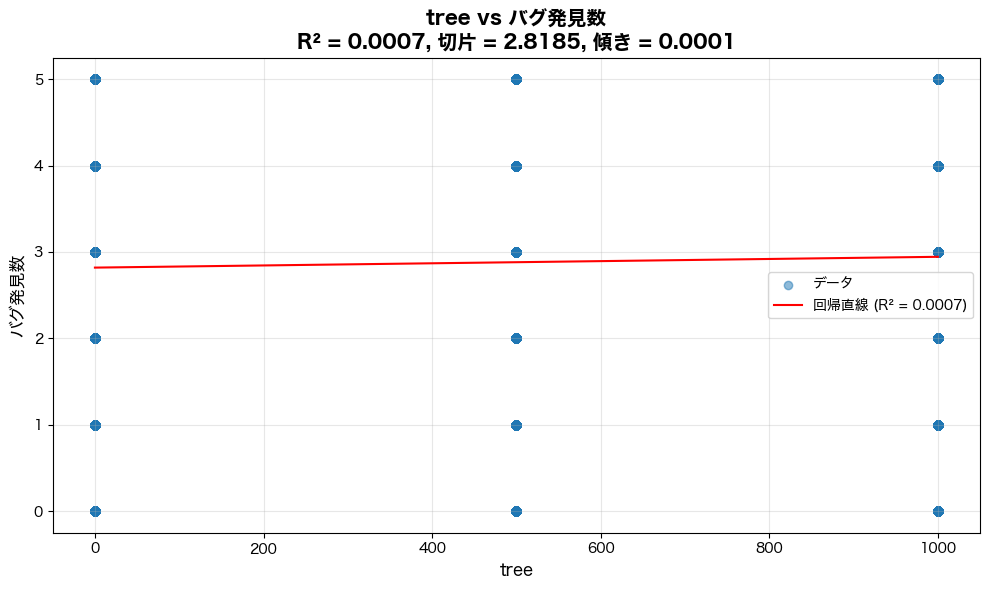


tree vs バグ発見数
  決定係数 (R²): 0.0007
  切片: 2.8185
  傾き: 0.0001
  サンプル数: 10800

分析: tree vs バグ発見までの時間
107936.0


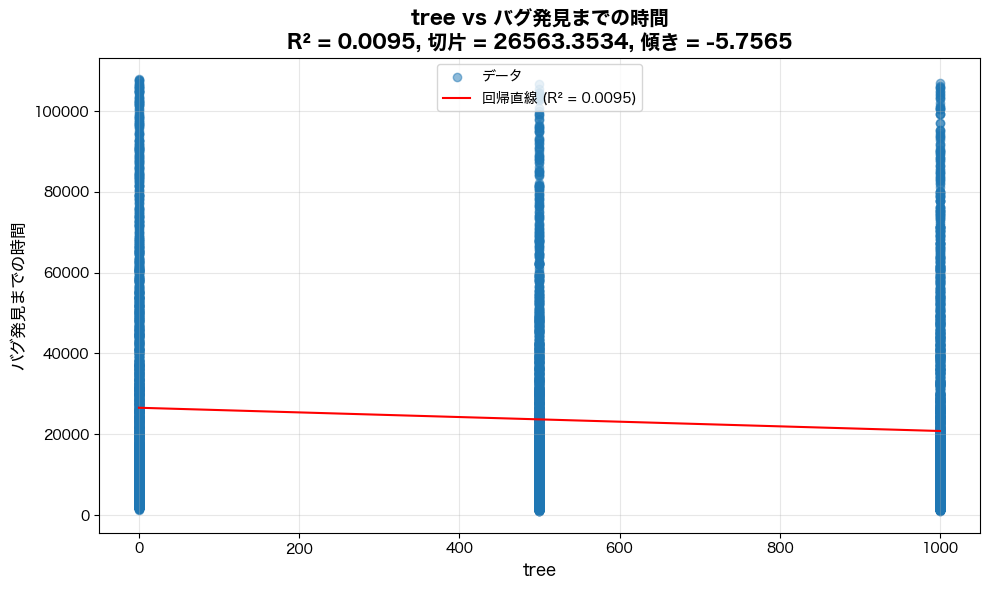


tree vs バグ発見までの時間
  決定係数 (R²): 0.0095
  切片: 26563.3534
  傾き: -5.7565
  サンプル数: 6223

分析: tree vs 実行時間
108000


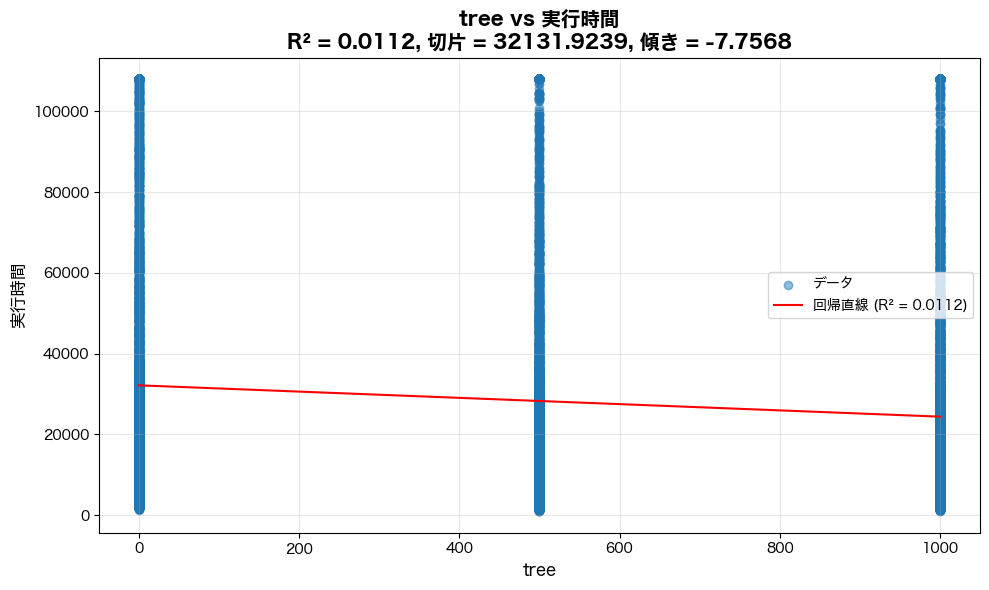


tree vs 実行時間
  決定係数 (R²): 0.0112
  切片: 32131.9239
  傾き: -7.7568
  サンプル数: 10800


In [44]:
# 単回帰分析とグラフ作成関数
def perform_simple_regression(X, y, x_label, y_label, title):
    """
    単回帰分析を実行し、グラフを作成
    
    Args:
        X: 説明変数（1次元配列）
        y: 目的変数（1次元配列）
        x_label: X軸ラベル
        y_label: Y軸ラベル
        title: グラフタイトル
    
    Returns:
        float: 決定係数 (R²)
    """
    # NaN値を除外
    mask = ~(np.isnan(X) | np.isnan(y))
    X_clean = X[mask]
    y_clean = y[mask]
    
    if len(X_clean) == 0:
        print(f"警告: {title} - 有効なデータがありません")
        return None
    
    # 定数項を追加（statsmodelsのOLSはデフォルトで切片を含まないため）
    X_with_const = sm.add_constant(X_clean)
    
    # 単回帰分析
    model = sm.OLS(y_clean, X_with_const).fit()
    
    # 決定係数
    r_squared = model.rsquared
    
    # グラフ作成
    plt.figure(figsize=(10, 6))
    plt.scatter(X_clean, y_clean, alpha=0.5, label='データ')
    
    # 回帰直線をプロット
    X_line = np.linspace(X_clean.min(), X_clean.max(), 100)
    X_line_with_const = sm.add_constant(X_line)
    y_pred = model.predict(X_line_with_const)
    plt.plot(X_line, y_pred, 'r-', label=f'回帰直線 (R² = {r_squared:.4f})')
    
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(f'{title}\nR² = {r_squared:.4f}, 切片 = {model.params[0]:.4f}, 傾き = {model.params[1]:.4f}', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 統計情報を表示
    print(f"\n{title}")
    print(f"  決定係数 (R²): {r_squared:.4f}")
    print(f"  切片: {model.params[0]:.4f}")
    print(f"  傾き: {model.params[1]:.4f}")
    print(f"  サンプル数: {len(X_clean)}")
    
    return r_squared

# 説明変数と目的変数の定義
explanatory_vars = {
    'cpNum': 'cpNum',
    'cpNum_range': 'cpNum_range',
    'cpNum_dir': 'cpNum_dir',
    'tree': 'tree'
}

target_vars = {
    'bug_count': 'バグ発見数',
    'bug_time': 'バグ発見までの時間',
    'execution_time': '実行時間'
}

# 各組み合わせで単回帰分析を実行
results = {}

for exp_var_key, exp_var_label in explanatory_vars.items():
    for target_var_key, target_var_label in target_vars.items():
        title = f'{exp_var_label} vs {target_var_label}'
        print(f"\n{'='*60}")
        print(f"分析: {title}")
        print('='*60)
        
        X = df[exp_var_key].values
        y = df[target_var_key].values
        
        if len(X) == 0 or len(y) == 0:
            print(f"警告: {title} - 有効なデータがありません")
            continue
        
        print(max(y))
        
        r_squared = perform_simple_regression(
            X, y, 
            x_label=exp_var_label, 
            y_label=target_var_label, 
            title=title
        )
        
        if r_squared is not None:
            results[f'{exp_var_key}_{target_var_key}'] = r_squared



決定係数のまとめ
       説明変数      目的変数  決定係数 (R²)
      cpNum     バグ発見数   0.035731
      cpNum バグ発見までの時間   0.000673
      cpNum      実行時間   0.071345
cpNum_range     バグ発見数   0.440994
cpNum_range バグ発見までの時間   0.037666
cpNum_range      実行時間   0.012719
  cpNum_dir     バグ発見数   0.000406
  cpNum_dir バグ発見までの時間   0.000223
  cpNum_dir      実行時間   0.000133
       tree     バグ発見数   0.000686
       tree バグ発見までの時間   0.009537
       tree      実行時間   0.011158


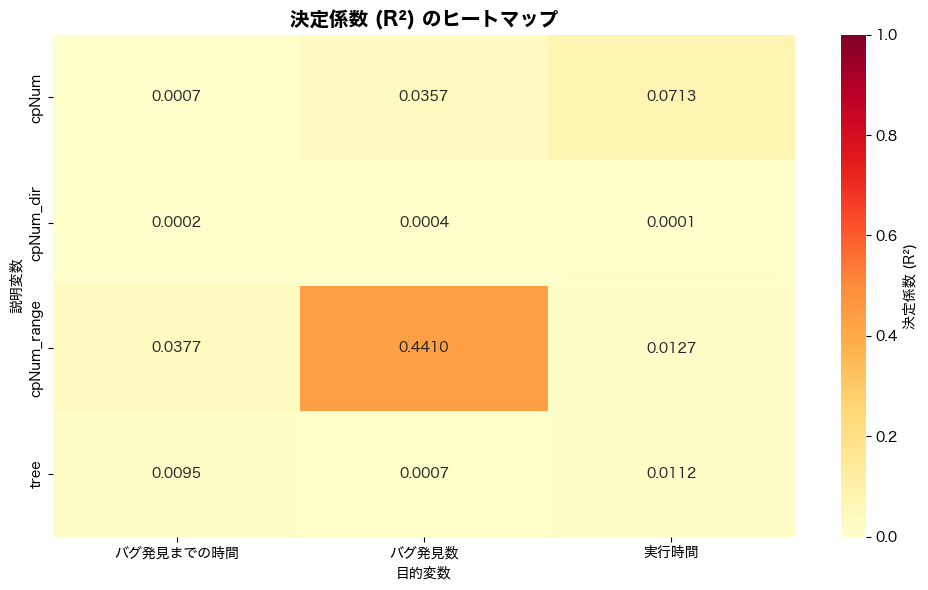

In [45]:
# 決定係数のまとめ表を作成
if results:
    results_df = pd.DataFrame([
        {
            '説明変数': exp_var_label,
            '目的変数': target_var_label,
            '決定係数 (R²)': results.get(f'{exp_var_key}_{target_var_key}', None)
        }
        for exp_var_key, exp_var_label in explanatory_vars.items()
        for target_var_key, target_var_label in target_vars.items()
    ])
    
    # NaNを除外
    results_df = results_df.dropna()
    
    print("\n" + "="*60)
    print("決定係数のまとめ")
    print("="*60)
    print(results_df.to_string(index=False))
    
    # 決定係数のヒートマップを作成
    pivot_table = results_df.pivot(index='説明変数', columns='目的変数', values='決定係数 (R²)')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlOrRd', 
                cbar_kws={'label': '決定係数 (R²)'}, vmin=0, vmax=1)
    plt.title('決定係数 (R²) のヒートマップ', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("結果がありません")
